<a href="https://colab.research.google.com/github/dnrocha/deepts/blob/master/C%C3%B3digo_Deep_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>##  INSTITUTO FEDERAL DO NORTE DE MINAS GERAIS - CAMPUS MONTES CLAROS
>
>
> # **Aprendizagem Profunda Para Transferência de Estilo entre Imagens Digitais**
>
>
> ### Autor: Luis Meazzini
>
> ### Discente: Daniel Antunes Rocha


In [0]:
# !cat /proc/meminfo
# !cat /proc/cpuinfo
# !pip3 install tensorflow==1.8
# !pip3 install keras
# !pip3 install torch torchvision
# !apt-get install python-numpy python-scipy


import numpy as np
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b


# -------------------------------------------- #
#           Definição de Parâmetros            #
# -------------------------------------------- #

peso_conteudo = 0.005
peso_estilo = 10.5
variacao_peso = 1.3
variacao_fator_custo = 1.25
media_rgb_imagenet = [123.68, 116.779, 103.939]
# media_rgb_imagenet = [0, 0, 0]
largura_imagem = 520    
altura_imagem = 520
canais = 3 # R G B

# -------------------------------------------- #
#            Importação de Imagens             #
# -------------------------------------------- #
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

img_entrada = Image.open('/tmp/nst/Tuebingen_Neckarfront.jpg')
img_entrada = img_entrada.resize((altura_imagem,largura_imagem))

img_estilo = Image.open('/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
img_estilo = img_estilo.resize((altura_imagem,largura_imagem))

# -------------------------------------------- #
#            Linearização de Imagens           #
# -------------------------------------------- #

img_entrada_arr = np.asarray(img_entrada, "float32")
img_entrada_arr = np.expand_dims(img_entrada_arr, axis=0)
img_entrada_arr[:, :, :, 0] -= media_rgb_imagenet[2]
img_entrada_arr[:, :, :, 1] -= media_rgb_imagenet[1]
img_entrada_arr[:, :, :, 2] -= media_rgb_imagenet[0]
img_entrada_arr = img_entrada_arr[:, :, :, ::-1] # Troca BGR por RGB


img_estilo_arr = np.asarray(img_estilo, "float32")
img_estilo_arr = np.expand_dims(img_estilo_arr, axis=0)
img_estilo_arr[:, :, :, 0] -= media_rgb_imagenet[2]
img_estilo_arr[:, :, :, 1] -= media_rgb_imagenet[1]
img_estilo_arr[:, :, :, 2] -= media_rgb_imagenet[0]
img_estilo_arr = img_estilo_arr[:, :, :, ::-1] # Troca BGR por RGB

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Invocando o Deep Learning**


In [0]:
entrada = K.variable(img_entrada_arr)
estilo = K.variable(img_estilo_arr)
imagem_combinada = K.placeholder((1, largura_imagem, altura_imagem, canais))

tensor_entrada = K.concatenate([entrada, estilo, imagem_combinada], axis=0)
model = VGG16(input_tensor=tensor_entrada, include_top=False, weights='imagenet')

# Função do Custo de Conteúdo

In [0]:
def custo_conteudo(conteudo, combinacao):
    return K.sum(K.square(combinacao - conteudo))

layers = dict([(layer.name, layer.output) for layer in model.layers])

camada_conteudo = 'block2_conv2'
camada_caracteristicas = layers[camada_conteudo]
camada_conteudo_caracteristicas = camada_caracteristicas[0, :, :, :]
caracteristicas_combinacao = camada_caracteristicas[2, :, :, :]

custo = K.variable(0.)
custo = peso_conteudo * custo_conteudo(camada_conteudo_caracteristicas, caracteristicas_combinacao)

# Função do Custo de Estilo

In [0]:
def gram_matrix(x):
    caracteristicas = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(caracteristicas, K.transpose(caracteristicas))
    return gram

def calc_custo_estilo(estilo, combinacao):
    estilo = gram_matrix(estilo)
    combinacao = gram_matrix(combinacao)
    tamanho = largura_imagem * altura_imagem
    return K.sum(K.square(estilo - combinacao))/ (4. * (canais ** 2) * (tamanho ** 2))

camadas_estilo = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for nome in camadas_estilo:
  caracteristicas_camada = layers[nome]
  caracteristicas_estilo = caracteristicas_camada[1, : , :, :]
  caracteristicas_combinacao = caracteristicas_camada[2, :, :, :]
  custo_estilo = calc_custo_estilo(caracteristicas_estilo, caracteristicas_combinacao)
  custo += (peso_estilo / len(camadas_estilo)) * custo_estilo

# Função do Custo de Variação Total

In [0]:
def custo_variacao_total(x):
  a = K.square(x[ :, :largura_imagem-1, :altura_imagem-1, :] - x[ :, 1:, :altura_imagem-1, :])
  b = K.square(x[ :, :largura_imagem-1, :altura_imagem-1, :] - x[ :, :altura_imagem-1, 1:, :])

  return K.sum(K.pow(a+b, variacao_fator_custo))

custo += variacao_peso * custo_variacao_total(imagem_combinada)

# Otimização

In [0]:
saidas = [custo]
saidas += K.gradients(custo, imagem_combinada)

def calculo_custo_e_gradientes(x):
    x = x.reshape((1, largura_imagem, altura_imagem, canais))
    outs = K.function([imagem_combinada], saidas)([x])
    custo = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return custo, gradients


class Evaluator: 
    def custo(self, x):
        custo, gradients = calculo_custo_e_gradientes(x)
        self._gradientes = gradients 
        return custo
    
    def gradientes(self, x):
        return self._gradientes

evaluator = Evaluator()

# -------------------------------------------- #
#        Utilizando Otimizador l-bfgs          #
# -------------------------------------------- #

x = np.random.uniform(0, 255, (1, largura_imagem, altura_imagem, canais)) - 128 
n = 10 # numero de iteracoes
#for i in range(n):
#    x, custo, info = fmin_l_bfgs_b(evaluator.custo, x.flatten(), fprime=evaluator.gradientes, maxfun=20)
#    print("Iteracao %d completa com custo: %d " % (i+1, custo))

for i in range(n):
    x, custo, info = fmin_l_bfgs_b(evaluator.custo, x.flatten(), fprime=evaluator.gradientes, maxfun=20)
    print("Iteracao %d completa com custo: %d" % (i + 1, custo))

x = x.reshape((largura_imagem, altura_imagem, canais))
x = x[ :, :, ::-1] # BGR para RGB

#retira normalizacao pela média ImageNet
x[ :, :, 0] += media_rgb_imagenet[2]
x[ :, :, 1] += media_rgb_imagenet[1]
x[ :, :, 2] += media_rgb_imagenet[0]

x = np.clip(x, 0, 255).astype("uint8") #mantem os valores entre 0 e 255
output_image = Image.fromarray(x)
output_image.save('output.png')

Iteracao 1 completa com custo: 56155017216
Iteracao 2 completa com custo: 26342565888
Iteracao 3 completa com custo: 18997579776
Iteracao 4 completa com custo: 16188020736
Iteracao 5 completa com custo: 14738606080
Iteracao 6 completa com custo: 13851966464
Iteracao 7 completa com custo: 13213847552
Iteracao 8 completa com custo: 12730475520
Iteracao 9 completa com custo: 12346327040
Iteracao 10 completa com custo: 12050014208


/content/drive/My Drive/Colab Notebooks/tcc


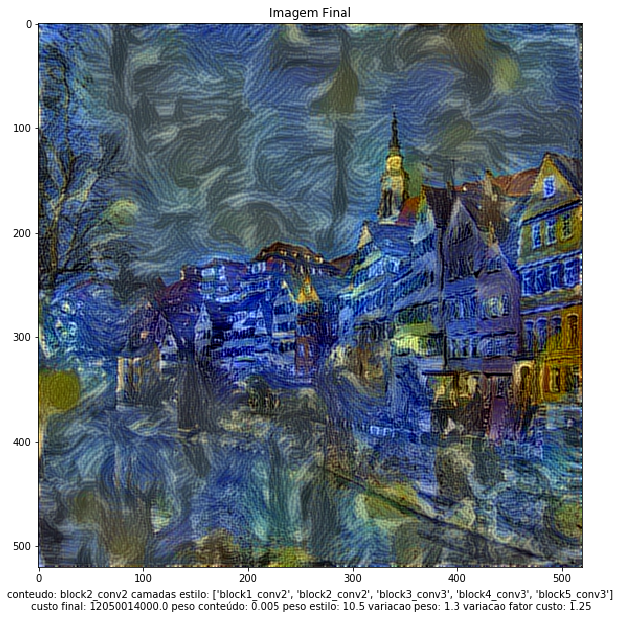

In [0]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/tcc
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.imshow(output_image)
subtitle = "conteudo: " + str(camada_conteudo) + " camadas estilo: " + str(camadas_estilo) + "\n custo final: " + str(custo) + " peso conteúdo: " + str(peso_conteudo) + " peso estilo: " + str(peso_estilo) + " variacao peso: " + str(variacao_peso) + " variacao fator custo: " + str(variacao_fator_custo)
plt.title('Imagem Final')
plt.xlabel(subtitle)
plt.savefig("resultado_"+str(custo)+".png")
plt.show()







In [0]:
# !ls
# %cd /content/drive/My\ Drive/Colab\ Notebooks/tcc

# !ls

'output (2).png'	       resultado_12050014000.0.png
'output (3).png'	       resultado_15509914000.0_original.png
'output (4).png'	       resultado_30052751000.0.png
'output (5).png'	       resultado_36086650000.0.png
 output.png		       resultado_38205260000.0.png
 resultado_11329186000.0.png
/content/drive/My Drive/Colab Notebooks/tcc
'output (2).png'	       resultado_12050014000.0.png
'output (3).png'	       resultado_15509914000.0_original.png
'output (4).png'	       resultado_30052751000.0.png
'output (5).png'	       resultado_36086650000.0.png
 output.png		       resultado_38205260000.0.png
 resultado_11329186000.0.png
